In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For Directml Gpu Configurations
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

In [2]:
train_data_raw = np.loadtxt(open("../Datasets/mnist_train.csv", "rb"), delimiter=",")
test_data_raw = np.loadtxt(open("../Datasets/mnist_test.csv", "rb"), delimiter=",")

train_data = train_data_raw[:, 1:]
train_labels = train_data_raw[:, 0]
test_data = test_data_raw[:, 1:]
test_labels = test_data_raw[:, 0]

print(f"Train data shape: {train_data.shape, train_labels.shape}")
print(f"Test data shape: {test_data.shape, test_labels.shape}")

Train data shape: ((60000, 784), (60000,))
Test data shape: ((10000, 784), (10000,))


In [4]:
# Data normalization

train_data_norm = train_data / np.max(train_data)
test_data_norm = test_data / np.max(test_data)

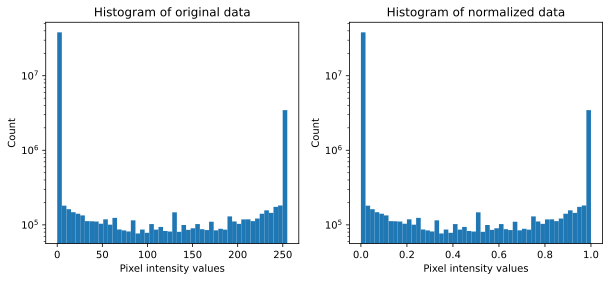

In [5]:
# Plot the data to see the data distribution
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(train_data.flatten(), 50)
ax[0].set_xlabel("Pixel intensity values")
ax[0].set_ylabel("Count")
ax[0].set_title("Histogram of original data")
ax[0].set_yscale("log")

ax[1].hist(train_data_norm.flatten(), 50)
ax[1].set_xlabel("Pixel intensity values")
ax[1].set_ylabel("Count")
ax[1].set_title("Histogram of normalized data")
ax[1].set_yscale("log")

plt.show()

In [8]:
### Create train and test groups using dataloader
# Convert to tensor
train_data_tensor = torch.tensor(train_data_norm).float()
train_labels_tensor = torch.tensor(train_labels).long()
test_data_tensor = torch.tensor(test_data_norm).float()
test_labels_tensor = torch.tensor(test_labels).long()

# Convert into pytorch dataset
train_dataT = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataT = TensorDataset(test_data_tensor, test_labels_tensor)

# Translate to dataloader objects
batchsize = 32
train_loader = DataLoader(
    train_dataT,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)

test_loader = DataLoader(
    test_dataT,
    batch_size=test_dataT.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [9]:
# Create the model function
def createNewMNISTNet(lr=0.01):
    # Model class
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(784, 64)

            # Hidden Layers
            self.hidden1 = nn.Linear(64, 32)
            self.hidden2 = nn.Linear(32, 32)

            # Output Layer
            self.output = nn.Linear(32, 10)

        # Forward Pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))
            return self.output(x)

    # Model Instance
    net = mnistNet()
    # Loss Function
    lossFun = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    return net, lossFun, optimizer

In [ ]:
# Function to train the model
nEpochs = 10


def trainTheModel():
    net, lossFun, optimizer = createNewMNISTNet()

    # Initialize losses
    losses = torch.zeros(nEpochs)
    trainAcc = []
    testAcc = []

    # The Loop
    for epoch in range(nEpochs):
        # Train Mode
        net.train()
        # Loop over batches
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss
            batchLoss.append(loss.cpu().item())

            # Compute Batch Accuracy
            batchAcc.append(
                100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu()
            )

        # End of batch Loop
        # Average Loss
        losses[epoch] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        # Dev Accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        testAcc.append(
            100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu()
        )
    # End of epoch

    return trainAcc, testAcc, losses, net

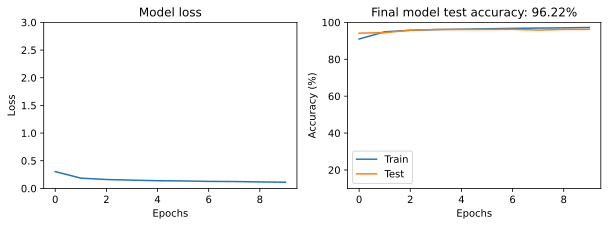

In [12]:
trainAcc, testAcc, losses, net = trainTheModel()

# visualization starts here
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(losses.cpu())
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {testAcc[-1]:.2f}%")
ax[1].legend()

plt.show()